### BDP Final Project: Twitter Credibility Analysis on Special Education - Part 2-1 EDA & Tweeter Category

In [1]:
spark.version

'3.1.3'

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')

import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore')

from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan,when,count
import matplotlib.pyplot as plt

In [3]:
# List all files in given COS directory
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)

    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns=['Name','Size'])

    blobs_df.style.format({"Size": "{:,.0f}"}) 
    
    return blobs_df

In [4]:
from google.cloud import storage
# Reading data from open bucket
path = 'gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part1_V1'

In [5]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [6]:
edu_df = spark.read.parquet(path)

In [7]:
edu_df.count()

33490185

In [8]:
# check the filter data
edu_df.limit(5)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_created_time,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id
1514974123751088133,0,Fri Apr 15 14:29:...,0,en,join us 4/25 for ...,1189250547355811840,MIT.nano,We measure the fu...,1522,1501,false,Tue Oct 29 18:40:...,null,null,null,,null,null,null,null,null,null,null,null
1514974131434971140,0,Fri Apr 15 14:29:...,0,en,a teacher for mor...,819662390149214208,dan marshall,Ontario correctio...,243,11515,false,Thu Jan 12 21:48:...,null,null,null,RT,EAlexander46,Fri Apr 15 13:12:...,231,54,9,[],1351258907113648128,1514954830141399040
1514974131766366210,0,Fri Apr 15 14:29:...,0,en,my intro to polit...,312384480,Taylor Brown,Christian. @oksta...,1862,38201,false,Tue Jun 07 01:40:...,null,null,null,,null,null,null,null,null,null,null,null
1514974133758861315,0,Fri Apr 15 14:29:...,0,en,covid is back aga...,1075449971623714816,Bhukya khethavath...,Just keep working...,609,12582,false,Wed Dec 19 17:57:...,null,null,null,RT,anubha1812,Thu Apr 14 15:11:...,993,598,147,[],159060077,1514622485248954372
1514974133918085129,0,Fri Apr 15 14:29:...,0,en,nevada basketball...,1021833553829613573,Nevada Sports Net,Your go-to source...,7348,3516,true,Tue Jul 24 19:04:...,null,null,null,RT,ByChrisMurray,Fri Apr 15 14:28:...,0,2,0,[],40287046,1514973870847332356


In [9]:
edu_df.columns

['tweet_id',
 'tweet_likes',
 'time_tweet_created',
 'tweet_reply_count',
 'language',
 'tweet_text',
 'user_id',
 'user_name',
 'user_description',
 'user_followers_count',
 'user_like_count',
 'verified_user',
 'time_account_created',
 'location',
 'country_name',
 'country_code',
 'is_retweeted',
 'retweeted_from',
 'rt_created_time',
 'rt_likes',
 'rt_count',
 'rt_reply_count',
 'rt_hashtags',
 'rt_usr_id',
 'rt_id']

In [10]:
edu_df.groupBy('language').count().orderBy('count', ascending=False).show()

+--------+--------+
|language|   count|
+--------+--------+
|      en|33490185|
+--------+--------+



In [11]:
edu_df.groupBy('is_retweeted').count().orderBy('count', ascending=False).show()

+------------+--------+
|is_retweeted|   count|
+------------+--------+
|          RT|21541524|
|            |11948661|
+------------+--------+



In [12]:
edu_df = edu_df.withColumn("original_tweet", when(col('is_retweeted') == 'RT', False).otherwise(True))

In [13]:
edu_df = edu_df.withColumn("is_retweeted", when(col('is_retweeted') == 'RT', True).otherwise(False))

In [14]:
edu_df.limit(5)

23/03/06 16:19:15 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_created_time,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet
1610254675001110529,0,Tue Jan 03 12:40:...,0,en,always a pleasure...,1288114132235857924,Subhasmita Nayak,Always happy 😊,917,7415,false,Tue Jul 28 14:08:...,null,null,null,true,dpradhanbjp,Tue Jan 03 10:43:...,119,49,4,[],1897514666,1610225363032100864,false
1610254681997201409,0,Tue Jan 03 12:40:...,0,en,x4 ready to atten...,1558026597625634816,Rosita 🐐,null,6,0,false,Fri Aug 12 09:44:...,null,null,null,false,null,null,null,null,null,null,null,null,true
1610254687080689664,0,Tue Jan 03 12:40:...,0,en,national college ...,1525184996046254082,Aishath SHaroo,null,100,38,false,Fri May 13 18:43:...,null,null,null,false,null,null,null,null,null,null,null,null,true
1610254689408516096,0,Tue Jan 03 12:40:...,0,en,this 192nd birth ...,1570741388119244803,Vikas saini RYMP,null,463,5741,false,Fri Sep 16 11:48:...,null,null,null,true,BaudhSumit,Mon Jan 02 18:43:...,241,21,14,[],2941310341,1609983741241458688,false
1610254690771517441,0,Tue Jan 03 12:40:...,0,en,the current situa...,1284623231358558208,Kimme W. 🍊,null,78,542,false,Sat Jul 18 22:57:...,null,null,null,true,RadioGenova,Tue Jan 03 06:40:...,897,511,0,[],1429400366819512323,1610164134661832709,false


In [15]:
bucket_write='msca-bdp-students-bucket'
folder_write = 'shared_data/chihhan/final_project_part2_V1'

In [16]:
edu_df.write.format("parquet").\
mode('overwrite').\
save('gs://' + bucket_write + '/'+folder_write)

In [17]:
!hadoop fs -ls 'gs://msca-bdp-students-bucket/shared_data/chihhan'

Found 5 items
drwx------   - root root          0 2023-03-04 01:06 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part1_V1
drwx------   - root root          0 2023-03-04 15:02 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part1_V2
drwx------   - root root          0 2023-03-05 07:52 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_2
drwx------   - root root          0 2023-03-06 16:23 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_V1
drwx------   - root root          0 2023-03-06 06:30 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_data_type


In [18]:
edu_df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_V1')

In [19]:
edu_df.limit(5)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_created_time,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet
1617931587441819649,0,Tue Jan 24 17:05:...,0,en,@clhubes i watche...,1284488917,Radical Liberal N...,Overeducated old ...,956,248947,false,Wed Mar 20 22:52:...,null,null,null,false,null,null,null,null,null,null,null,null,true
1617931589593489409,0,Tue Jan 24 17:05:...,0,en,let it be on reco...,2782764480,Kittam Kittu,RT's are not endo...,704,270293,false,Sun Aug 31 19:27:...,null,null,null,true,RavensLaire,Tue Jan 24 09:35:...,401,155,19,[],106894917,1617818481738776576,false
1617931590428164096,0,Tue Jan 24 17:05:...,0,en,hb 3001 would pro...,964587979,Elżbieta Januszki...,«that cunt» -a pe...,103,67453,false,Thu Nov 22 16:47:...,null,null,null,true,ash_in_wv,Tue Jan 24 16:48:...,2,3,0,[],1375284197305286656,1617927418030981120,false
1617931592730808320,0,Tue Jan 24 17:05:...,0,en,@senwarren educat...,1245396704565829633,JengaNeck,"Woman, Wife, Wres...",195,55703,false,Wed Apr 01 17:05:...,null,null,null,false,VP @TheDemocrats ...,null,null,null,null,null,null,null,true
1617931596979671040,0,Tue Jan 24 17:05:...,0,en,profile of niagar...,249287480,Bernie Puchalski,Tweets about spor...,1109,1,false,Tue Feb 08 18:59:...,null,null,null,false,null,null,null,null,null,null,null,null,true


### Part 2: EDA

- see how many tweets are retweets

In [20]:
edu_df.groupBy('is_retweeted').count().orderBy('count', ascending=False).show()

+------------+--------+
|is_retweeted|   count|
+------------+--------+
|        true|21541524|
|       false|11948661|
+------------+--------+



- see how many tweets are original tweets

In [21]:
edu_df.groupBy('original_tweet').count().orderBy('count', ascending=False).show()

+--------------+--------+
|original_tweet|   count|
+--------------+--------+
|         false|21541524|
|          true|11948661|
+--------------+--------+



- see the tweet counts by location

In [22]:
edu_df.groupBy('location').count().orderBy('count', ascending=False).show()

+--------------------+--------+
|            location|   count|
+--------------------+--------+
|                null|33198628|
|Riyadh, Kingdom o...|   11905|
|         Houston, TX|    4073|
|          Texas, USA|    4004|
|        Florida, USA|    3631|
|     Los Angeles, CA|    3246|
|        Georgia, USA|    2731|
|       Manhattan, NY|    2689|
|الرياض, المملكة ا...|    2680|
|         Chicago, IL|    2319|
|      Washington, DC|    1777|
|   Pennsylvania, USA|    1729|
|        Brooklyn, NY|    1678|
| North Carolina, USA|    1676|
|    New Delhi, India|    1652|
|     San Antonio, TX|    1650|
|         Atlanta, GA|    1559|
| South Carolina, USA|    1559|
|          Austin, TX|    1504|
|    Philadelphia, PA|    1407|
+--------------------+--------+
only showing top 20 rows



In [23]:
edu_df.filter(col('location').isNotNull())\
         .groupBy('location').count().orderBy(col('count').desc()).limit(20)

location,count
"Riyadh, Kingdom o...",11905
"Houston, TX",4073
"Texas, USA",4004
"Florida, USA",3631
"Los Angeles, CA",3246
"Georgia, USA",2731
"Manhattan, NY",2689
"الرياض, المملكة ا...",2680
"Chicago, IL",2319
"Washington, DC",1777


- see the tweet counts by country

In [24]:
edu_df.groupBy('country_name').count().orderBy('count', ascending=False).show()

+--------------------+--------+
|        country_name|   count|
+--------------------+--------+
|                null|33198628|
|       United States|  201415|
|               India|   20112|
|      United Kingdom|   17500|
|Kingdom of Saudi ...|   12046|
|              Canada|    6405|
|             Nigeria|    3774|
|           Australia|    2795|
|المملكة العربية ا...|    2728|
|             Ireland|    2278|
|Republic of the P...|    2260|
|            Pakistan|    2002|
|        South Africa|    1812|
|               Kenya|    1490|
|               Ghana|     847|
|              Uganda|     836|
|            Malaysia|     511|
|United Arab Emirates|     449|
|         New Zealand|     439|
|             Germany|     411|
+--------------------+--------+
only showing top 20 rows



In [25]:
edu_df.filter(col('country_name').isNotNull())\
         .groupBy('country_name').count().orderBy(col('count').desc()).limit(20)

country_name,count
United States,201415
India,20112
United Kingdom,17500
Kingdom of Saudi ...,12046
Canada,6405
Nigeria,3774
Australia,2795
المملكة العربية ا...,2728
Ireland,2278
Republic of the P...,2260


- Tweets group by language

In [26]:
edu_df.groupBy('language').count().orderBy('count', ascending=False).show()

+--------+--------+
|language|   count|
+--------+--------+
|      en|33490185|
+--------+--------+



- Tweets group by verified user

In [27]:
edu_df.groupBy('verified_user').count().orderBy('count', ascending=False).show()

+-------------+--------+
|verified_user|   count|
+-------------+--------+
|        false|32903652|
|         true|  586533|
+-------------+--------+



In [28]:
verified = edu_df.select(['user_id', 'verified_user'])
verified.groupby('verified_user').count()

verified_user,count
true,586533
false,32903652


#### **Twitterer's categories(which organization it belongs to)**

##### **Categorize Twitterers into different categories by searching keywords in user_name & user_description column**
    - Organization: 
        1. government entities
        2. universities
        3. schools
        4. nonprofit organizations
        5. news outlets
        6. social media influencers
        7. someone else

In [29]:
edu_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ['user_name', 'user_description']]).show()

+---------+----------------+
|user_name|user_description|
+---------+----------------+
|      502|         5924043|
+---------+----------------+



In [30]:
edu_df = edu_df.withColumn("user_description",F.lower(F.col("user_description")))

In [31]:
edu_df.select('user_description').take(10)

[Row(user_description='overeducated old decrepit internist/psychiatrist/longtime know-it-all/diehard wvu mountaineer fan.......not sure whether i’m a metropolitan narcissist.'),
 Row(user_description="rt's are not endorsements."),
 Row(user_description="«that cunt» -a person i've only ever had brief neutral interactions with"),
 Row(user_description="woman, wife, wrestling fan, artist, reader, gamer, comic enthusiast, singer and political skeptic. spiritual but anti-religious. i don't accept dms"),
 Row(user_description='tweets about sports in niagara from three decades of experience.'),
 Row(user_description='💖'),
 Row(user_description='help us'),
 Row(user_description='sane human being| strong woman👸🏻, lover of life🌼🌼 travis 💫 ya allah 🤲🏻, fatee fatee ❤️'),
 Row(user_description="🇭🇹 | chief hype officer at nascar |  rise esports gm | just a kid from vermont | it's a great day to be alive 🙏🏾"),
 Row(user_description='head coach + recruiting advisor * serve others, bring out their best

In [32]:
edu_df = edu_df.withColumn("user_name",F.lower(F.col("user_name")))

In [33]:
edu_df.select('user_name').take(10)

[Row(user_name='radical liberal nasty dr. mom parody☮️😉🍑”😷😷!”'),
 Row(user_name='kittam kittu'),
 Row(user_name='elżbieta januszkiewicz'),
 Row(user_name='jenganeck'),
 Row(user_name='bernie puchalski'),
 Row(user_name='annie 🦋'),
 Row(user_name='kg ❄️ fangio szn'),
 Row(user_name='a j o k e'),
 Row(user_name='black mamba'),
 Row(user_name='mike mertz | va glory national')]

In [34]:
gov_entities = ['senator', 'senate', 'congressman', 'congresswoman', 'mayor', 'president', 'vice president' ,'senat', 'congress',\
                'prime minister', 'minister', 'parliament', 'white house', 'mayor', 'democrat', 'republican', 'government',\
               'elected officials', 'governors', 'federal', 'army', 'supreme court', 'politician']

universities = ['universit(y)?(ies)?', 'colleg(e)?(es)?', 'academy', 'higher education', 'institution', 'professor', 'TA', 'teaching assistant']

schools = ['public school', 'private school', 'middle school', 'elementary school', 'junior high', 'senior high',\
           'primary school', 'secondary school', 'high school', 'vocational school', 'kindergarten', 'teacher', 'counselor', 'graduation']

ngos = [ 'non(-)?profit', 'ngo', 'NGO', 'foundation', 'non(-)?profit organization', 'not(-)?for(-)?profit',\
        'charity', 'nongovernmental organization', 'non-governmental organization', 'private voluntary organization',\
        'non-governmental development organization', 'civil society', 'community-based organization', "people's organization",\
       'grassroots organization', 'donor-organized', 'civil society', 'social movements']

news = ['breaking story', 'news article', 'report', 'times', 'daily', 'post', 'news', 'newspaper', 'reporter', 'journalist',\
        'exclusive', 'live broadcast', 'coverage', 'editorial', 'live broadcast', 'press conference', 'news anchor', 'correspondent']

influencer = [ 'youtuber', 'singer', 'writer', 'musician', 'author', 'entrepreneur', 'actor', 'actress', 'director', 'creater',\
             'expert', 'writer', 'curator', 'photographer', 'activist', 'thought leader', 'poet', 'musician', 'comedian', 'comedy writer',\
             'humorist', 'technologist', 'techie', 'geek', 'instagrammer', 'filter filterer', 'fashionista', 'micro-blogger', 'model',\
             'instgator', 'fashion expert', 'foodie', 'make up artist', 'vlogger', 'evangelist', 'trend rider', 'film maker']

In [35]:
# check if the user name and description is null
tweeter_cat = edu_df.filter(edu_df.user_name.isNotNull() & edu_df.user_description.isNotNull())

# tagging users
tweeter_cat = tweeter_cat.withColumn("twitterer_catogory",\
                                        F.when((tweeter_cat.user_description.rlike('|'.join(gov_entities)))|\
                                               (tweeter_cat.user_name.rlike('|'.join(gov_entities))), 'government_entities') \
                                         .when((tweeter_cat.user_description.rlike('|'.join(universities)))|\
                                               (tweeter_cat.user_name.rlike('|'.join(universities))), 'schools') \
                                         .when((tweeter_cat.user_description.rlike('|'.join(schools)))\
                                               | (tweeter_cat.user_name.rlike('|'.join(schools))), 'universities') \
                                         .when((tweeter_cat.user_description.rlike('|'.join(ngos)))| \
                                               (tweeter_cat.user_name.rlike('|'.join(ngos))), 'news_media') \
                                         .when((tweeter_cat.user_description.rlike('|'.join(news)))| \
                                               (tweeter_cat.user_name.rlike('|'.join(news))), 'ngo') \
                                         .when(((tweeter_cat.user_followers_count >= 50000) & \
                                                (tweeter_cat.user_description.rlike('|'.join(influencer)))) | \
                                                  ((tweeter_cat.user_name.rlike('|'.join(influencer))) & \
                                               (tweeter_cat.user_followers_count >= 50000)), 'Influencer') \
                                         .otherwise('other'))

In [36]:
tweeter_cat.limit(5)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_created_time,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet,twitterer_catogory
1609295925494661125,0,Sat Dec 31 21:10:...,0,en,2022 (academics) ...,223643557,miss sam,"a life of faith,a...",5225,4002,false,Mon Dec 06 23:20:...,null,null,null,true,xorlaliplange,Sat Dec 31 17:49:...,294,61,13,[],713856387315589121,1609245304901050371,false,other
1609295925578530824,0,Sat Dec 31 21:10:...,0,en,the median ifr fo...,834624054099337216,babydoll92196 wha...,love our country ...,740,35591,false,Thu Feb 23 04:40:...,null,null,null,true,PatriotSkyrific,Fri Dec 30 23:09:...,96,43,1,[],826112727311589376,1608963400851419137,false,other
1609295925700169729,0,Sat Dec 31 21:10:...,0,en,on this date: de...,30293881,steve,life's tough less...,504,57357,false,Fri Apr 10 19:38:...,null,null,null,true,PSPhoto1,Sat Dec 31 16:38:...,3,1,0,[],560840893,1609227402613501954,false,other
1609295926086225920,0,Sat Dec 31 21:10:...,0,en,one of my best fr...,38926376,lily lane,queen of hearts e...,11095,11157,true,Sat May 09 20:56:...,null,null,null,false,null,null,null,null,null,null,null,null,true,other
1609295927210303494,0,Sat Dec 31 21:10:...,0,en,🔴𝐖𝐚𝐭𝐜𝐡 𝐍𝐨...,793154106,dazn free tv,@daznfreetv - daz...,151,2166,false,Fri Aug 31 05:37:...,null,null,null,true,AccessHDTV,Sat Dec 31 21:09:...,3,2,0,[],487548590,1609295814014402561,false,other


In [37]:
tweeter_cat.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- tweet_likes: long (nullable = true)
 |-- time_tweet_created: string (nullable = true)
 |-- tweet_reply_count: long (nullable = true)
 |-- language: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_followers_count: long (nullable = true)
 |-- user_like_count: long (nullable = true)
 |-- verified_user: boolean (nullable = true)
 |-- time_account_created: string (nullable = true)
 |-- location: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- is_retweeted: boolean (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- rt_created_time: string (nullable = true)
 |-- rt_likes: long (nullable = true)
 |-- rt_count: long (nullable = true)
 |-- rt_reply_count: long (nullable = true)
 |-- rt_hashtags: array (nullabl

In [38]:
tweeter_cat.count()

27566156

In [39]:
tweeter_cat.groupBy('twitterer_catogory').count().orderBy('count', ascending=False).show()

+-------------------+--------+
| twitterer_catogory|   count|
+-------------------+--------+
|              other|22416636|
|                ngo| 1444876|
|            schools| 1358307|
|government_entities| 1114838|
|       universities|  987698|
|         news_media|  203318|
|         Influencer|   40483|
+-------------------+--------+



#### **- Total tweet count by categories**

In [40]:
total_tweet_org = tweeter_cat.groupBy('twitterer_catogory').count().orderBy('count', ascending=False).toPandas()
total_tweet_org

,twitterer_catogory,count
0,other,22416636
1,ngo,1444876
2,schools,1358307
3,government_entities,1114838
4,universities,987698
5,news_media,203318
6,Influencer,40483


In [41]:
total_tweet_org['%'] = (total_tweet_org['count'] / total_tweet_org['count'].sum())*100
total_tweet_org

,twitterer_catogory,count,%
0,other,22416636,81.319412
1,ngo,1444876,5.241485
2,schools,1358307,4.927444
3,government_entities,1114838,4.044227
4,universities,987698,3.583010
5,news_media,203318,0.737564
6,Influencer,40483,0.146858


In [42]:
type(total_tweet_org)

pandas.core.frame.DataFrame

In [43]:
# eliminate others to have a clearer view
total_tweet_org2 = total_tweet_org[total_tweet_org['twitterer_catogory'] != 'other']
total_tweet_org2

,twitterer_catogory,count,%
1,ngo,1444876,5.241485
2,schools,1358307,4.927444
3,government_entities,1114838,4.044227
4,universities,987698,3.583010
5,news_media,203318,0.737564
6,Influencer,40483,0.146858


In [44]:
total_tweet_org2['%'] = (total_tweet_org2['count'] / total_tweet_org2['count'].sum())*100
total_tweet_org2

,twitterer_catogory,count,%
1,ngo,1444876,28.058460
2,schools,1358307,26.377352
3,government_entities,1114838,21.649358
4,universities,987698,19.180390
5,news_media,203318,3.948290
6,Influencer,40483,0.786151


In [45]:
total_tweet_org2.replace({'news_media': 'News & Media', 'universities': 'Universities', 'schools': 'Schools',
                           'ngo': 'NGOs' , 'government_entities': 'Government Entities'}, inplace=True)
total_tweet_org2

,twitterer_catogory,count,%
1,NGOs,1444876,28.058460
2,Schools,1358307,26.377352
3,Government Entities,1114838,21.649358
4,Universities,987698,19.180390
5,News & Media,203318,3.948290
6,Influencer,40483,0.786151


##### - **Visualization**

Text(0.5, 1.0, 'Organizations by Amount of Total Tweets Regarding Special Education')

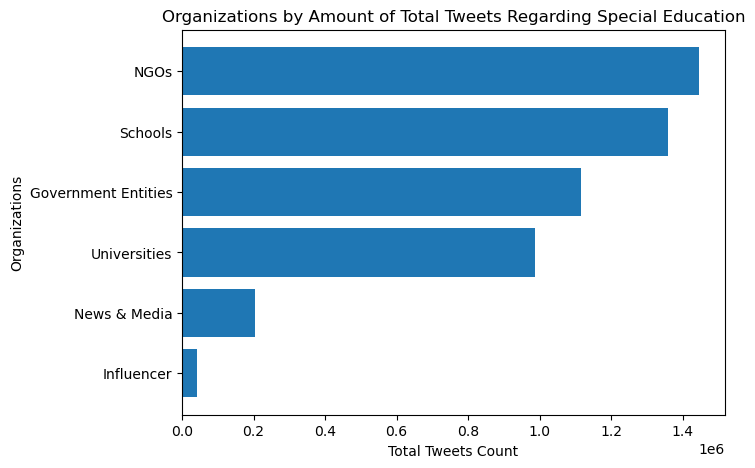

In [46]:
fig, ax = plt.subplots(figsize =(7, 5)) 
ax.barh(total_tweet_org2['twitterer_catogory'], total_tweet_org2['count'])
ax.invert_yaxis()
plt.xlabel('Total Tweets Count')
plt.ylabel('Organizations')
plt.title('Organizations by Amount of Total Tweets Regarding Special Education')

<AxesSubplot:ylabel='count'>

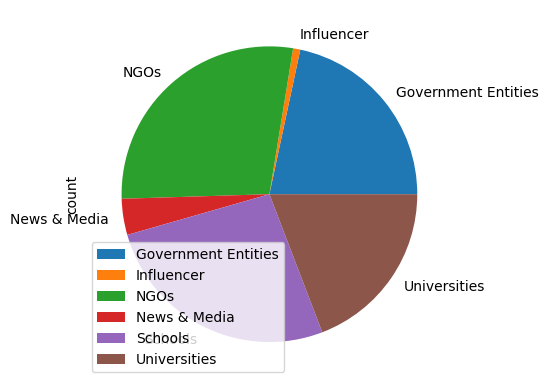

In [47]:
total_tweet_org2.groupby(['twitterer_catogory']).sum().plot(kind='pie', y='count')

No handles with labels found to put in legend.


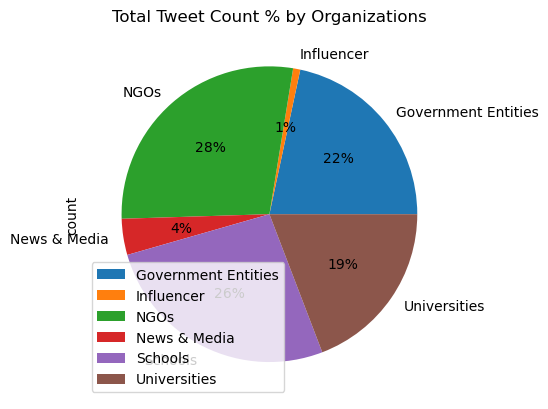

In [48]:
total_tweet_org2.groupby(['twitterer_catogory']).sum().plot(kind='pie', y='count', autopct='%1.0f%%',
                                #colors = ['darkred', 'pink', 'steelblue', 'purple', 'darkblue', 'brown'],
                                title='Total Tweet Count % by Organizations')
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

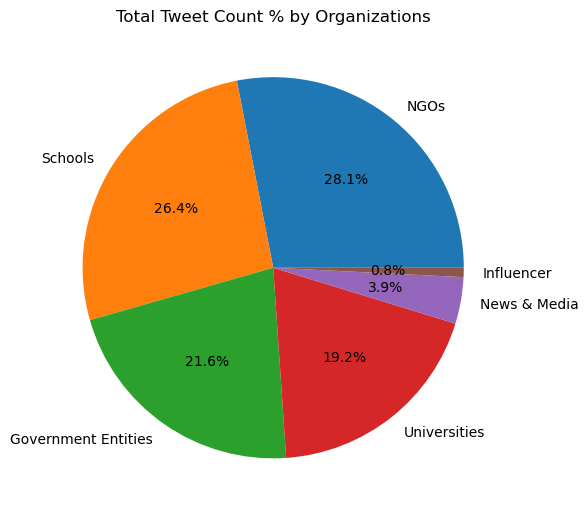

In [49]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie( total_tweet_org2['count'], labels= total_tweet_org2['twitterer_catogory'], autopct='%.1f%%')
ax.set_title('Total Tweet Count % by Organizations')
plt.tight_layout()

#### **- Original Tweet count by categories**

In [50]:
org_tweet_org = tweeter_cat.select('original_tweet', 'twitterer_catogory').filter(col('original_tweet') == True).\
                groupBy('twitterer_catogory').count().orderBy('count', ascending=False).toPandas()
org_tweet_org

,twitterer_catogory,count
0,other,7841224
1,ngo,735914
2,schools,708012
3,universities,432216
4,government_entities,338078
5,news_media,87825
6,Influencer,13915


In [51]:
orginal_tweet_org = org_tweet_org[org_tweet_org['twitterer_catogory'] != 'other']
orginal_tweet_org['%'] = (orginal_tweet_org['count'] / orginal_tweet_org['count'].sum())*100
orginal_tweet_org.replace({'news_media': 'News & Media', 'universities': 'Universities', 'schools': 'Schools',
                           'ngo': 'NGOs' , 'government_entities': 'Government Entities'}, inplace=True)
orginal_tweet_org

,twitterer_catogory,count,%
1,NGOs,735914,31.775765
2,Schools,708012,30.570994
3,Universities,432216,18.662498
4,Government Entities,338078,14.597748
5,News & Media,87825,3.792164
6,Influencer,13915,0.600831


##### - **Visualization**

Text(0.5, 1.0, 'Organizations by Amount of Original Tweets Regarding Special Education')

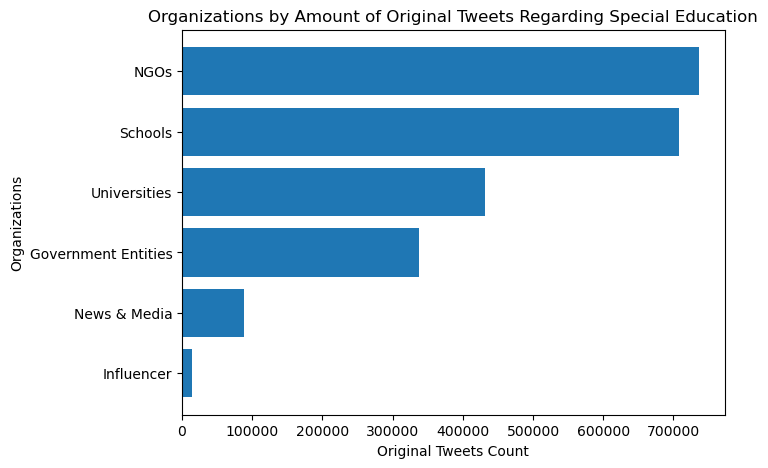

In [52]:
fig, ax = plt.subplots(figsize =(7, 5)) 
ax.barh(orginal_tweet_org['twitterer_catogory'], orginal_tweet_org['count'])
ax.invert_yaxis()
plt.xlabel('Original Tweets Count')
plt.ylabel('Organizations')
plt.title('Organizations by Amount of Original Tweets Regarding Special Education')

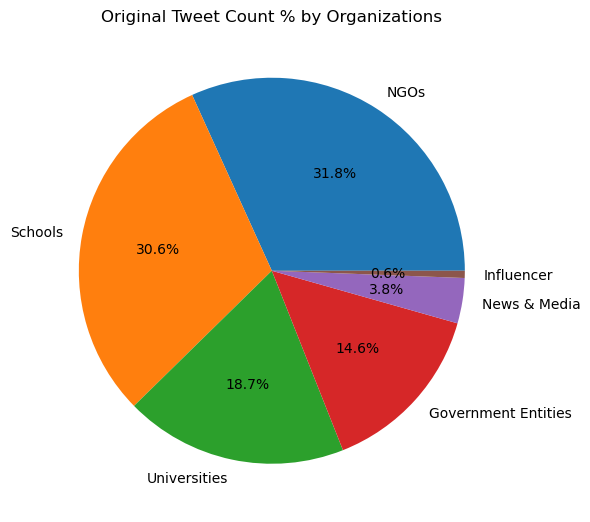

In [53]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(orginal_tweet_org['count'], labels= orginal_tweet_org['twitterer_catogory'], autopct='%.1f%%')
ax.set_title('Original Tweet Count % by Organizations')
plt.tight_layout()

#### **- Retweet count by categories**

In [ ]:
retweet_org = tweeter_cat.select('is_retweeted', 'twitterer_catogory').filter(col('is_retweeted') == True).\
                groupBy('twitterer_catogory').count().orderBy('count', ascending=False).toPandas()
retweet_org

,twitterer_catogory,count
0,other,14575412
1,government_entities,776760
2,ngo,708962
3,schools,650295
4,universities,555482
5,news_media,115493
6,Influencer,26568


In [ ]:
retweet_org = retweet_org[retweet_org['twitterer_catogory'] != 'other']
retweet_org['%'] = (retweet_org['count'] / retweet_org['count'].sum())*100
retweet_org.replace({'news_media': 'News & Media', 'universities': 'Universities', 'schools': 'Schools',
                           'ngo': 'NGOs' , 'government_entities': 'Government Entities'}, inplace=True)
retweet_org

,twitterer_catogory,count,%
1,Government Entities,776760,27.412866
2,NGOs,708962,25.020187
3,Schools,650295,22.949752
4,Universities,555482,19.603679
5,News & Media,115493,4.075897
6,Influencer,26568,0.937619


##### - **Visualization**

Text(0.5, 1.0, 'Organizations by Amount of Retweets Regarding Special Education')

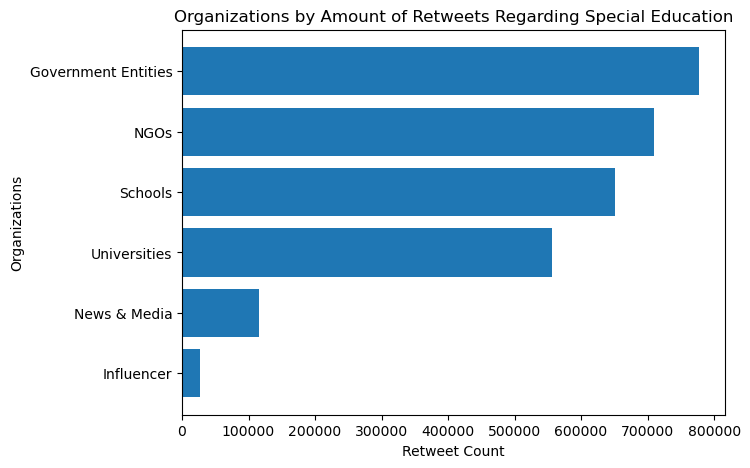

In [ ]:
fig, ax = plt.subplots(figsize =(7, 5)) 
ax.barh(retweet_org['twitterer_catogory'], retweet_org['count'])
ax.invert_yaxis()
plt.xlabel('Retweet Count')
plt.ylabel('Organizations')
plt.title('Organizations by Amount of Retweets Regarding Special Education')

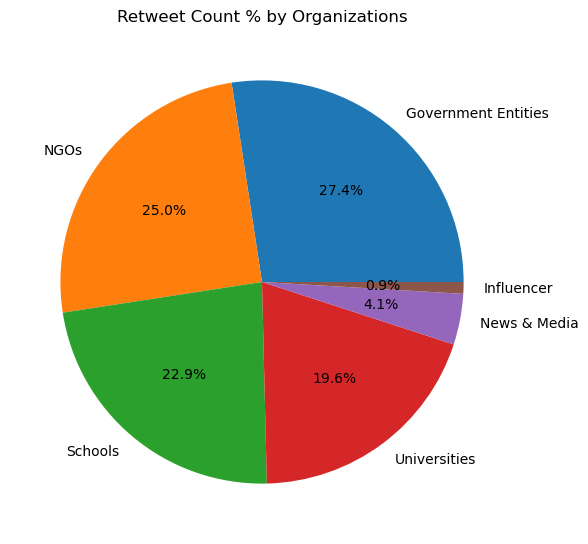

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(retweet_org['count'], labels= retweet_org['twitterer_catogory'], autopct='%.1f%%')
ax.set_title('Retweet Count % by Organizations')
plt.tight_layout()

- At Hootsuite, we organize influencer types by the following sizes:
    - Nano-influencer: 1,000–10,000 followers
    - Micro-influencer: 10,000–50,000 followers
    - Mid-tier influencer: 50,000–500,000 followers
    - Macro-influencer: 500,000–1,000,000 followers
    - Mega-influencers: 1,000,000+ followers



- Reference: 
    - Influencer's definition
        -  https://blog.hootsuite.com/how-much-do-influencers-make/#:~:text=10%2C000%E2%80%9350%2C000%20followers%20%3D%20Micro%2D,1%2C000%2C000%2B%20followers%20%3D%20Mega%2Dinfluencers
        -  https://influencermarketinghub.com/what-is-an-influencer/
        -  https://getgist.com/influencer-synonyms/
    - Government departments & agencies
        - https://www.usa.gov/federal-agencies
    - Ngos:
        - https://www.gdrc.org/ngo/ngo-keywords.html
    - Universities/ Schools/ News:
        - ChatGPT

##### **Save the result of twetter's category into individual bucket(final_project_part2_2)**

In [ ]:
bucket_write='msca-bdp-students-bucket'
folder_write = 'shared_data/chihhan/final_project_part2_2'

In [ ]:
tweeter_cat.write.format("parquet").\
mode('overwrite').\
save('gs://' + bucket_write + '/'+folder_write)

In [ ]:
!hadoop fs -ls 'gs://msca-bdp-students-bucket/shared_data/chihhan'

Found 5 items
drwx------   - root root          0 2023-03-04 01:06 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part1_V1
drwx------   - root root          0 2023-03-04 15:02 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part1_V2
drwx------   - root root          0 2023-03-06 16:49 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_2
drwx------   - root root          0 2023-03-06 16:23 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_V1
drwx------   - root root          0 2023-03-06 06:30 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_data_type


In [ ]:
twitterer_cat_data = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_2')

In [ ]:
# check the filter data
twitterer_cat_data.limit(5)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_created_time,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet,twitterer_catogory
1541790989152575488,0,Tue Jun 28 14:29:...,0,en,@mechellelori you...,1406138101362274304,the spry old lorax,i speak for me: a...,2195,7040,false,Sat Jun 19 06:34:...,null,null,null,false,null,null,null,null,null,null,null,null,true,government_entities
1541790990024974339,0,Tue Jun 28 14:29:...,0,en,free education un...,753215841655746560,larry l. robinson...,is a 17 course cu...,88,3,false,Wed Jul 13 13:13:...,null,null,null,false,null,null,null,null,null,null,null,null,true,schools
1541790992340291585,0,Tue Jun 28 14:29:...,0,en,@narendramodi @mo...,1419248235885912069,dr piyas ghosh,mbbs ( kyiv medic...,80,12078,false,Sun Jul 25 10:51:...,null,null,null,true,videshidoctor,Tue Jun 28 14:28:...,2,1,0,[],1465925467127664640,1541790754863218691,false,schools
1541790993133064192,0,Tue Jun 28 14:29:...,0,en,any on-duty taxpa...,992011398602510336,anne,"wife, mom, grammy...",1561,64715,false,Thu May 03 12:02:...,null,null,null,true,RepRaskin,Mon Jun 27 21:27:...,18275,3596,1535,[],806906355214852096,1541533617473699841,false,ngo
1541790993481089025,0,Tue Jun 28 14:29:...,0,en,hey #teachertwitt...,2663441359,teresa cooper,creative & love h...,1287,1833,false,Sun Jul 20 15:42:...,null,null,null,true,MsDee6781,Tue Jun 28 14:23:...,7,10,2,"[teachertwitter, ...",1136088165989662720,1541789398437601285,false,other


In [ ]:
twitterer_cat_data.count()

27566156

####  **2.1 Identify the most prolific / influential Twitterers**

##### **By message volume (original content)**

In [ ]:
edu_df.select('user_id', 'original_tweet').filter(col('original_tweet') == True).\
groupby('user_id').count().sort(col('count').desc())

user_id,count
219401992,9284
66263683,8264
1426164518581899266,7337
1549115944735481856,7333
1272479318447230977,6953
1434562949381767177,5597
1448701295318216704,4551
1448410354363551747,4485
1170532065965555712,4268
1389966784527147008,3926


In [ ]:
tweeter_cat.select('user_id', 'user_name', 'user_description', 'twitterer_catogory').filter(col('original_tweet') == True).filter(col('user_id') == 219401992)

user_id,user_name,user_description,twitterer_catogory
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools
219401992,dennis stemmle,founder - college...,schools


In [ ]:
type(tweeter_cat)

pyspark.sql.dataframe.DataFrame

In [ ]:
top_20 = tweeter_cat.select('user_id', 'user_name', 'user_description','twitterer_catogory').filter(col('original_tweet') == True).\
groupby('user_id', 'user_name', 'twitterer_catogory').count().sort(col('count').desc()).toPandas()[:20]
top_20

,user_id,user_name,twitterer_catogory,count
0,219401992,dennis stemmle,schools,9284
1,66263683,njschooljobs.com,other,8264
2,1426164518581899266,"accepting light,urgent commissions",other,7091
3,1272479318447230977,a random user,other,6953
4,1434562949381767177,edibeeee,other,5597
5,1448701295318216704,sexual assault bot,ngo,4551
6,1170532065965555712,men's fashion tv 〜メンズファッションテレビ〜,other,4268
7,1389966784527147008,keen,other,3926
8,25739661,prepstar,other,3762
9,2868388510,sportsthread,schools,3157


In [ ]:
top_20['user_id']

0               219401992
1                66263683
2     1426164518581899266
3     1272479318447230977
4     1434562949381767177
5     1448701295318216704
6     1170532065965555712
7     1389966784527147008
8                25739661
9              2868388510
10    1562234314339012610
11    1554982001156947969
12    1325900968911798272
13    1408202907149815809
14     753215841655746560
15             1337927119
16     875107384535900161
17    1492515474055348224
18    1101270461986496512
19               49860518
Name: user_id, dtype: int64

In [ ]:
top_20_user_id = list(top_20['user_id'])
top_20_user_id

[219401992,
 66263683,
 1426164518581899266,
 1272479318447230977,
 1434562949381767177,
 1448701295318216704,
 1170532065965555712,
 1389966784527147008,
 25739661,
 2868388510,
 1562234314339012610,
 1554982001156947969,
 1325900968911798272,
 1408202907149815809,
 753215841655746560,
 1337927119,
 875107384535900161,
 1492515474055348224,
 1101270461986496512,
 49860518]

In [ ]:
top_20_original = tweeter_cat.select('user_id', 'user_name','twitterer_catogory').filter(col('original_tweet') == True).\
groupby('user_id', 'user_name', 'twitterer_catogory').count().sort(col('count').desc()).toPandas()[:20]
top_20_original

,user_id,user_name,twitterer_catogory,count
0,219401992,dennis stemmle,schools,9284
1,66263683,njschooljobs.com,other,8264
2,1426164518581899266,"accepting light,urgent commissions",other,7091
3,1272479318447230977,a random user,other,6953
4,1434562949381767177,edibeeee,other,5597
5,1448701295318216704,sexual assault bot,ngo,4551
6,1170532065965555712,men's fashion tv 〜メンズファッションテレビ〜,other,4268
7,1389966784527147008,keen,other,3926
8,25739661,prepstar,other,3762
9,2868388510,sportsthread,schools,3157


In [ ]:
# tweeter_cat.select('user_id', 'user_name', 'original_tweet', 'twitterer_catogory', 'original_tweet').filter(col('original_tweet') == True).\
# groupby('user_id', 'user_name').count().sort(col('count').desc()).toPandas()

In [ ]:
# top_20 = tweeter_cat.select('user_id','original_tweet').filter(col('original_tweet') == True).\
# groupby('user_id').count().sort(col('count').desc()).limit(20).select("user_id").rdd.flatMap(lambda x: x).collect()

In [ ]:
# top_20

In [ ]:
# tweeter_cat.select('user_id', 'user_name', 'user_description', 'twitterer_catogory', 'original_tweet').filter(col('original_tweet') == True).\
# groupby('user_id').count().sort(col('count').desc())

In [ ]:
tweeter_cat.count()

27566156

- **Who are these Twitterers ?**  
(government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)

- **Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations**

##### **By message retweet (how often their messages are being retweeted)**

In [ ]:
edu_df.select('user_id', 'is_retweeted').filter(col('is_retweeted') == True).\
groupby('user_id').count().sort(col('count').desc())

user_id,count
1038107559817830400,6567
1295715136141963267,5527
152936614,4778
1499577679401603089,3859
1311337818518556672,3672
1129718312466812930,3629
3224986553,2559
38321921,2072
115055995,1892
1164502444472033280,1810


In [ ]:
edu_df.select('user_id', 'user_name' , 'is_retweeted').filter(col('is_retweeted') == True).\
groupby('user_id', 'user_name').count().sort(col('count').desc())

user_id,user_name,count
1038107559817830400,james clark,6567
1295715136141963267,education world,5527
152936614,joe windon,4778
1499577679401603089,educationbnb,3859
1311337818518556672,academic opportun...,3672
1129718312466812930,rosina o,3629
3224986553,college esports,2559
1164502444472033280,nss rd chandigarh,1810
1491776087684104193,jobs via tweet,1766
1039965688000126977,mark johnson,1761


In [79]:
# top_20_retweet = tweeter_cat.select('user_id', 'user_name', 'user_description','twitterer_catogory').filter(col('is_retweeted') == True).\
# groupby('user_id', 'user_name', 'twitterer_catogory').count().sort(col('count').desc()).toPandas()[:20]

# top_20_retweet

##### **Use engagement rate to measure Twitterer's influence rather than use count**

##### **User influence score to measure Twitterer's influence rather than use count**

- Twitter engagement rate
     - engagement rate = (Retweet+ likes\number of tweets)\ Total number of followers))* 100
     - reference: https://getmashhor.com/en/twitter-engagement-calculator
     
     - Engagement rate on Twitter is calculated as the sum of: (Likes + Retweets + Quotes + Replies) divided by the number of tweets, then by the total number of followers, then multiplied by 100.
     - reference: https://mention.com/en/twitter-engagement-calculator/#:~:text=Engagement%20rate%20on%20Twitter%20is,followers%2C%20then%20multiplied%20by%20100.
     
- influence score:
    - Kred Influence = (Retweets + Replies) * (Followers + Following)
    - Retweet Reach (RTR) score = RTR = (Number of Retweets + Number of Mentions) / Number of Followers
    - Twitter Authority Score (TAS): TAS = log10(Followers) x log10(Statuses)
    - Followerwonk Social Authority score = Social Authority = (Retweets x 0.5) + (Mentions x 0.5)
    - (retweet_count / total tweet) * follower


- **Who are these Twitterers ?**  
(government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)

- **Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations**

In [ ]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")